In [1]:
%load_ext autoreload
%autoreload 2
from glob import glob
import os
from pathlib import Path
import re
import sys
import yaml
import datetime
import numpy as np
import pandas as pd
from tqdm import tqdm
from func.utils import get_categorical_features, read_pkl_gzip, to_pkl_gzip, parallel_load_data, get_filename, logger_func
from ieee_train import eval_train, eval_check_feature
from kaggle_utils import reduce_mem_usage, move_feature
logger = logger_func()

2019-09-13 00:37:33,575 func.utils 347 [INFO]    [logger_func] start 


In [2]:
COLUMN_ID = 'TransactionID'
COLUMN_DT = 'TransactionDT'
COLUMN_TARGET = 'isFraud'
COLUMN_GROUP = 'DT-M'
COLUMNS_IGNORE = [COLUMN_ID, COLUMN_DT, COLUMN_TARGET, COLUMN_GROUP, 'is_train', 'date']

def filter_feature(path):
    if path.count(''):
        return True
    else:
        return False

paths_train = glob('../feature/raw_use/*_train.gz')
paths_train = [path for path in paths_train if filter_feature(path) ]
paths_test = glob('../feature/raw_use/*_test.gz')
paths_test = [path for path in paths_test if filter_feature(path) ]

paths_train_feature = sorted(glob('../feature/org_use/*_train.gz'))
paths_test_feature  = sorted(glob('../feature/org_use/*_test.gz'))

# paths_train_feature += sorted(glob('../feature/valid/*_train.gz'))
# paths_test_feature  += sorted(glob('../feature/valid/*_test.gz'))

# paths_train_feature += sorted(glob('../feature/kernel/*_train.gz'))
# paths_test_feature  += sorted(glob('../feature/kernel/*_test.gz'))

paths_train_feature += sorted(glob('../feature/valid_use/*_train.gz'))
paths_test_feature  += sorted(glob('../feature/valid_use/*_test.gz'))

# df_train = reduce_mem_usage( parallel_load_data(paths_train) )
# df_test  = reduce_mem_usage( parallel_load_data(paths_test) )
df_train = parallel_load_data(paths_train)
df_test  = parallel_load_data(paths_test)
Y = df_train[COLUMN_TARGET]
df_train.drop(COLUMN_TARGET, axis=1, inplace=True)

  2%|▏         | 5/232 [00:00<00:05, 44.43it/s]

* Check Unique Feature.


100%|██████████| 232/232 [00:03<00:00, 59.72it/s]


All Features have info.
  * Diff Features: 0
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[141]	valid_0's auc: 0.899782


2019-09-13 00:38:08,945 func.utils 111 [INFO]    [ieee_cv]   * Fold0 2017-12: 0.899782132691246 


[  * Fold0 Validation-DT-M 2017-12: 134339] done in 20 s
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[121]	valid_0's auc: 0.937854


2019-09-13 00:38:27,934 func.utils 111 [INFO]    [ieee_cv]   * Fold1 2018-3: 0.9378535792660034 


[  * Fold1 Validation-DT-M 2018-3: 101968] done in 18 s
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[122]	valid_0's auc: 0.935463


2019-09-13 00:38:47,279 func.utils 111 [INFO]    [ieee_cv]   * Fold2 2018-1: 0.9354629606155143 


[  * Fold2 Validation-DT-M 2018-1: 92510] done in 18 s
Training until validation scores don't improve for 50 rounds.
[200]	valid_0's auc: 0.929825
Early stopping, best iteration is:
[155]	valid_0's auc: 0.930855


2019-09-13 00:39:09,465 func.utils 111 [INFO]    [ieee_cv]   * Fold3 2018-5: 0.9308553719672259 


[  * Fold3 Validation-DT-M 2018-5: 92427] done in 21 s
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[142]	valid_0's auc: 0.945238


2019-09-13 00:39:30,462 func.utils 111 [INFO]    [ieee_cv]   * Fold4 2018-2: 0.9452384660912901 


[  * Fold4 Validation-DT-M 2018-2: 85725] done in 20 s
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[148]	valid_0's auc: 0.952063


2019-09-13 00:39:52,022 func.utils 111 [INFO]    [ieee_cv]   * Fold5 2018-4: 0.9520630971266201 


[  * Fold5 Validation-DT-M 2018-4: 83571] done in 21 s
[  * Make Prediction Result File.] done in 49 s
* Check Corr with Past Submit.
  *  (506691,) (506691,)
  * LB0.9516 / 0.9079507509625828
  *  (506691,) (506691,)
  * LB0.95169 / 0.9516748155344225
  *  (506691,) (506691,)
  * LB0.9518 / 0.9616169916931924
  *  (506691,) (506691,)
  * LB0.9526 / 0.9445068729070004
* CV: 0.9335426012929834 | BestIter: 138.16666666666666
* Training Feature Importance


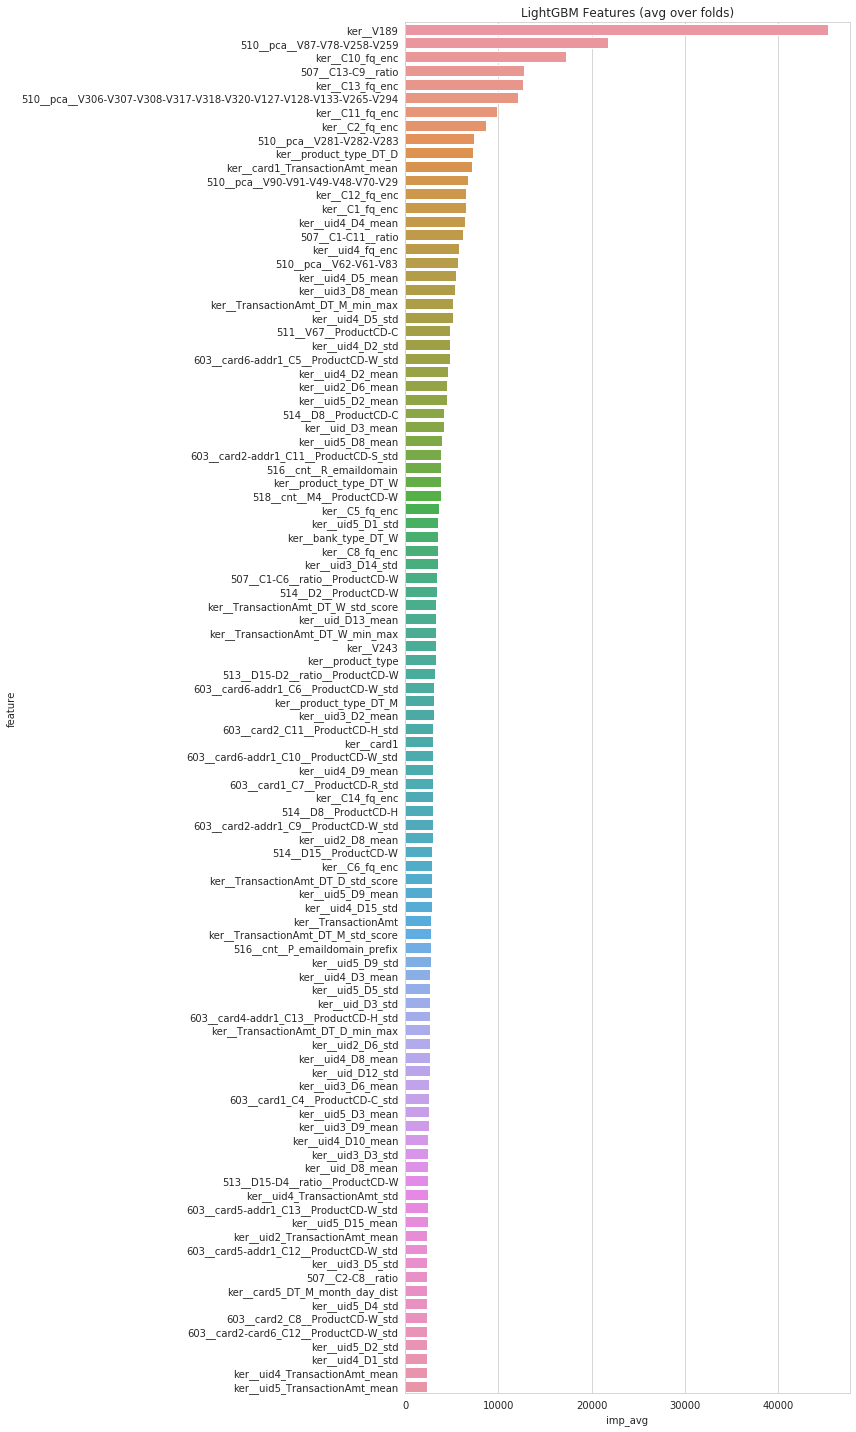

Setup Dataset dim_ml_dataset.


In [3]:
is_submit = [True, False][1]
valid_paths_train = paths_train_feature[:]
valid_paths_test  = paths_test_feature[:]

#========================================================================
# pathの存在チェック。なぜかたびたびFileNotFoundErrorが起きるので,,,
#========================================================================
remove_paths = []
for trn_path, tes_path in zip(valid_paths_train, valid_paths_test):
    if os.path.exists(trn_path) and os.path.exists(tes_path):
        pass
    else:
        remove_paths.append(trn_path)
        remove_paths.append(tes_path)
for path in remove_paths:
    if path.count('train'):
        valid_paths_train.remove(path)
        print(f'remove {path}')
    elif path.count('test'):
        valid_paths_test.remove(path)
        print(f'remove {path}')

df_feat_train = parallel_load_data(valid_paths_train)
df_feat_test  = parallel_load_data(valid_paths_test)

col_drops = eval_check_feature(df_feat_train, df_feat_test)

tmp_train = df_train.join(df_feat_train)
tmp_test = df_test.join(df_feat_test)

#========================================================================
# Train Test で片方に存在しないFeatureを除外
#========================================================================
diff_cols = list(set(tmp_train.columns) - set(tmp_test.columns))

for col in list(set(diff_cols)):
    from_dir = 'valid'
    to_dir = 'valid_trush'
    move_feature([col], from_dir, to_dir)
tmp_train.drop(diff_cols, axis=1, inplace=True)
print(f"  * Diff Features: {len(diff_cols)}")

# same_user_path = '../output/same_user_pattern/20190901_user_ids_share.csv'
# same_user_path = '../output/same_user_pattern/0902__same_user_id__card_addr_pemail_M.csv'
group_kfold_path = '../input/0908_ieee__DT-M_GroupKFold.gz'
group = read_pkl_gzip(group_kfold_path)
tmp_train[COLUMN_GROUP] = group


#========================================================================
# Features elimination 
#==============================================================
# from scipy.stats import ks_2samp
# features_check = []
# columns_to_check = set(list(tmp_train)).difference(COLUMNS_IGNORE)
# for i in columns_to_check:
#     features_check.append(ks_2samp(tmp_test[i], tmp_train[i])[1])

# features_check = pd.Series(features_check, index=columns_to_check).sort_values() 
# features_discard = list(features_check[features_check==0].index)
# print(features_discard)
# tmp_train.drop(features_discard, axis=1, inplace=True)
# tmp_test.drop(features_discard, axis=1, inplace=True)


model_type = "lgb"
params = {
#     'n_jobs': 64,
    'n_jobs': 32,
    'seed': 1208,
    'n_splits': 6,
    'metric': 'auc',
    'model_type': model_type,
    'objective': 'binary',
    'fold': ['stratified', 'group'][1],
    'num_leaves': 2**8-1,
    'max_depth': -1,
    'subsample': 0.9,
    'subsample_freq': 1,
    'colsample_bytree' : 0.20,
    'lambda_l1' : 0.1,
    'lambda_l2' : 1.0,
    'learning_rate' : 0.1,
    "early_stopping_rounds": 50,
}

if is_submit:
    params['learning_rate'] = 0.01
    params["early_stopping_rounds"] = 100

list_result_feim = eval_train(
    logger,
    tmp_train,
    Y,
    tmp_test,
    COLUMN_GROUP,
    model_type,
    params,
    is_adv=[True, False][1],
    is_viz=[True, False][0],
)

In [4]:
# feim = read_pkl_gzip('../output/feature_importances/20190912_0822__CV0-9456328818476605__feature726.gz')
# pd.set_option('max_rows', 200)
feim = list_result_feim[0]
# idx = [idx for idx in feim.index if idx.count('522_')]
# feim = feim.loc[idx]
feim.tail(100)
# feim.loc[[i for i in feim.index if i.count('browser')]]

,imp_fold1,imp_fold2,imp_fold3,imp_fold4,imp_fold5,imp_fold6,imp_avg
feature,,,,,,,
ker__card5_DT_W_week_day_dist_best,1056.606812,1155.258545,1318.756226,944.539062,933.706238,967.750122,1062.769409
518__label__M6__ProductCD-W,955.690369,1115.173706,1085.086426,1246.588867,1051.620728,911.310669,1060.911743
ker__uid2_D9_mean,979.452942,1043.934326,1328.734619,1001.140564,1109.614014,878.625610,1056.916870
ker__uid2_D4_std,1249.815063,1129.146118,1029.561890,1076.669189,931.420288,922.826050,1056.573120
ker__uid_D14_mean,930.177185,986.442566,1258.844116,868.926758,1115.468628,1117.631958,1046.248535
ker__uid5_D11_mean,1202.213745,941.389893,966.022644,1142.475220,1189.965820,808.630981,1041.783081
ker__uid_D15_mean,1297.678101,1384.150146,889.514465,679.523499,628.582214,1326.091064,1034.256470
ker__uid3_D12_mean,242.406631,484.947113,376.389526,621.993408,3951.628174,473.815491,1025.196655
ker__card1_fq_enc,884.596375,989.640320,1134.191650,980.944885,1041.399658,1103.334229,1022.351074


In [9]:
feim = read_pkl_gzip('../output/feature_importances/20190909_2324__CV0-9467296784440689__feature552.gz')
# for feature_name in feim[feim['imp_avg']<50].index:
for feature_name in feim.index:
#     if not feature_name.count('ker'):
#         continue

    if feature_name.count('raw'):
        from_dir = 'raw_use'
        to_dir = 'raw_trush'
#         from_dir = 'raw_trush'
#         to_dir = 'raw_use'
    else:
        from_dir = 'org_use'
        to_dir = 'org_trush'
#         from_dir = 'org_trush'
#         to_dir = 'org_use'
    from_dir = 'product_feature'
#     from_dir = 'kernel'
#     from_dir = 'check_trush'
#     from_dir = 'raw_trush'
#     from_dir = 'org_trush'
#     from_dir = 'useless'
    from_dir = 'valid_use'
#     from_dir = 'org_use'
#     to_dir = 'valid_trush'
#     to_dir = 'check_trush'
    to_dir = 'org_use'
#     to_dir = 'valid'
#     to_dir = 'kernel'
    try:
        move_feature([feature_name], from_dir, to_dir)
    except FileNotFoundError:
        print(feature_name)